# Inspection of variables after Full Selection

**_run with dfs created with the full selection_**

This notebook inspects the selected events after the full event selection 

In [1]:
%load_ext autoreload
%autoreload 2

#print all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path, makedirs
import sys
from tqdm import tqdm
import datetime

# local imports
sys.path.append('../../')
from analysis_village.numucc_1p0pi.selection_definitions import *
from analysis_village.numucc_1p0pi.variable_configs import VariableConfig
from analysis_village.numucc_1p0pi.utils import *
from analysis_village.numucc_1p0pi.makedf.util import *
from pyanalib.split_df_helpers import *
from pyanalib.stat_helpers import *
from pyanalib.pandas_helpers import *
from pyanalib.variable_calculator import get_cc1p0pi_tki
from pyanalib.pandas_helpers import pad_column_name
from makedf.constants import *

plt.style.use("presentation.mplstyle")
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
from matplotlib.offsetbox import AnchoredOffsetbox, DrawingArea, HPacker, VPacker, TextArea
from matplotlib.legend import Legend

In [3]:
save_fig = False
today_str = datetime.datetime.now().strftime("%Y%m%d")
print(today_str)
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/selected_events-{}".format(today_str)
if not path.exists(save_fig_dir):
    makedirs(save_fig_dir)

20260127


# Load dfs

In [11]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/2025Spring_v10_06_00_09"

## -- MC 
mc_file = path.join(file_dir, "MC", "BNB_cosmics", "aa.df")
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

## -- Data
data_file = path.join(file_dir, "data", "BNB", "mup.df")
data_split_df = pd.read_hdf(data_file, key="split")
data_n_split = get_n_split(data_file)
print("data_n_split: %d" %(data_n_split))
print_keys(data_file)

## -- Intime Data
intime_file = path.join(file_dir, "data", "OffBeam", "aa.df")
intime_split_df = pd.read_hdf(intime_file, key="split")
intime_n_split = get_n_split(intime_file)
print("intime_n_split: %d" %(intime_n_split))
print_keys(intime_file)

# concat dfs 
n_max_concat = 3

mc_keys2load = ['hdr', 'evt'] 
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']

data_keys2load = ['evt', 'hdr', 'bnbpot']
data_dfs = load_dfs(data_file, data_keys2load, n_max_concat=n_max_concat)
data_evt_df = data_dfs['evt']
data_hdr_df = data_dfs['hdr']
data_bnbpot_df = data_dfs['bnbpot']

intime_keys2load = ['hdr', 'evt']
intime_dfs = load_dfs(intime_file, intime_keys2load, n_max_concat=n_max_concat)
intime_hdr_df = intime_dfs['hdr']
intime_evt_df = intime_dfs['evt']

mc_n_split: 1
Keys: ['/evt_0', '/hdr_0', '/histpotdf_0', '/split']
data_n_split: 1
Keys: ['/bnbpot_0', '/evt_0', '/hdr_0', '/histgenevtdf_0', '/histpotdf_0', '/split']
intime_n_split: 1
Keys: ['/bnbpot_0', '/evt_0', '/hdr_0', '/histpotdf_0', '/split']


In [12]:
## total pot - scale to data POT

# BNB data
data_tot_pot = data_hdr_df['pot'].sum()
print("data_tot_pot: %.3e" %(data_tot_pot))
pot_str = "5.98 $\\times 10^{18}$"
data_evt_df["pot_weight"] = np.ones(len(data_evt_df))
data_gates = data_hdr_df.nbnbinfo.sum()
print("data tot gates : %.3e" %(data_gates))

# BNB MC
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))
mc_pot_scale = data_tot_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

# Intime Data
# intime_gates = intime_hdr.noffbeambnb.sum()
intime_gates = intime_hdr_df[intime_hdr_df['first_in_subrun'] == 1]['noffbeambnb'].sum()
print("intime cosmics data gates: {:.2e}".format(intime_gates))
f = 0.073
scale_intime_to_lightdata = (1-f)*data_gates/intime_gates
print("goal scale: {:.2f}".format(scale_intime_to_lightdata))
intime_evt_df["gates_weight"] = scale_intime_to_lightdata * np.ones(len(intime_evt_df))

data_tot_pot: 5.950e+18
data tot gates : 1.251e+06
mc_tot_pot: 1.518e+19
mc_pot_scale: 3.918e-01
intime cosmics data gates: 2.77e+07
goal scale: 0.04


In [40]:
# Load pre-calculated systematics, as an option
# import pickle
# with open("/exp/sbnd/app/users/munjung/xsec/cafpyana/analysis_village/numucc1p0pi/NuINT_uncs/tot_uncert_dict.pkl", "rb") as f:
#     syst_uncert_dict = pickle.load(f)
# syst_uncert_dict.keys()

In [17]:
plot_labels_bar = ["Events (POT={})".format(pot_str), "", ""]
plot_labels_hist = ["", "Events / Bin (POT={})".format(pot_str), ""]

# Distribution of Selected Events

In [29]:
save_fig = False
if save_fig:
    print("saving plots in ", save_fig_dir)

eps = 1e-8
syst = True
approval = "preliminary"
ax_ylim_ratio = 1.6

genie_unc [46.00225833 43.47173874 32.92621412 35.2947994  21.74195539 18.41624337
 16.6096282   9.34070925  9.2926675   9.22104335  6.73241861  5.46627006]
n_cv [491 344 216 145 100  67  85  47  39  32  23  22]


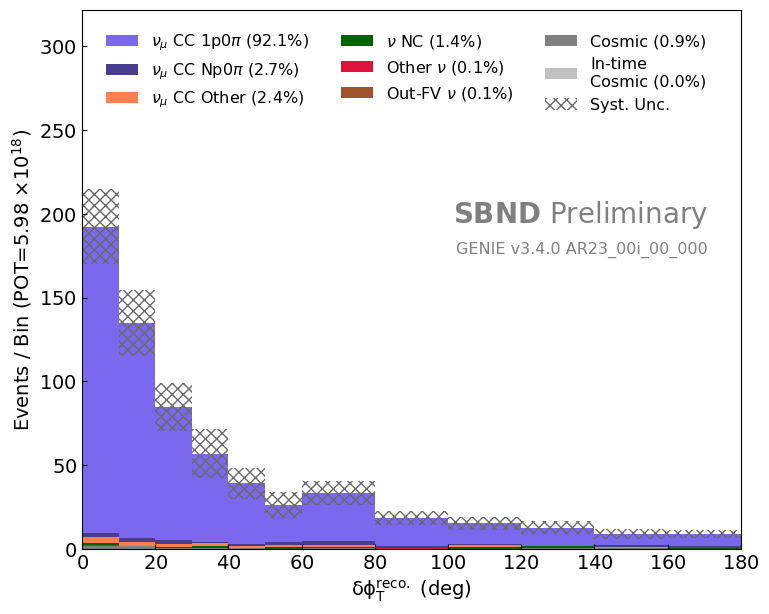

genie_unc [46.00225833 43.47173874 32.92621412 35.2947994  21.74195539 18.41624337
 16.6096282   9.34070925  9.2926675   9.22104335  6.73241861  5.46627006]
n_cv [491 344 216 145 100  67  85  47  39  32  23  22]


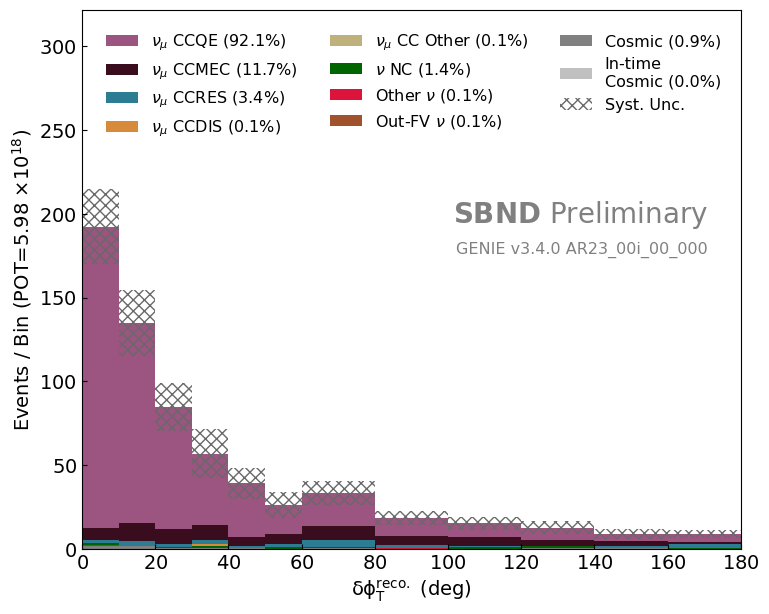

numu NC 22
[0.09369095 0.12637133 0.15243618 0.24341241 0.21741955 0.2748693
 0.19540739 0.19873849 0.23827353 0.2881576  0.29271385 0.24846682]
[0.06902876 0.07210914 0.07820442 0.08631355 0.09001157 0.09184348
 0.09707213 0.0976453  0.10043905 0.11435553 0.12172931 0.11581082]


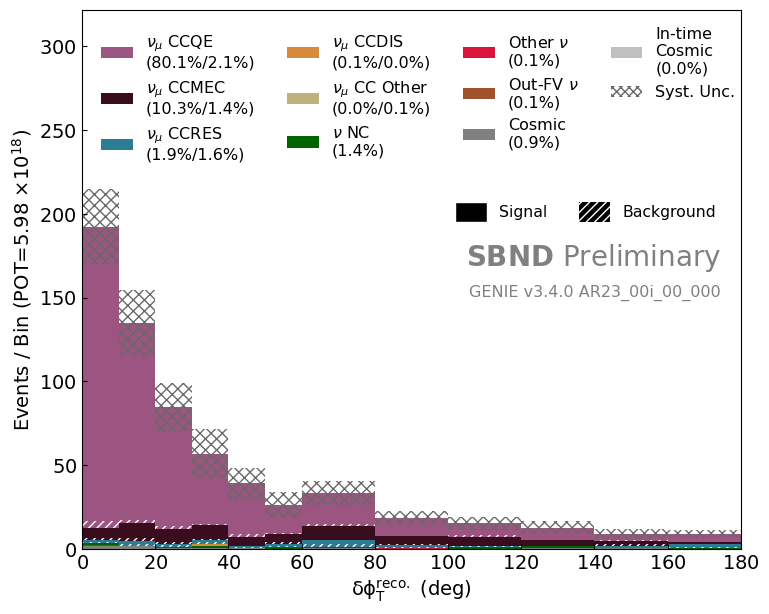

In [ ]:
var_config = VariableConfig.muon_momentum()
# var_config = VariableConfig.muon_direction()
# var_config = VariableConfig.proton_momentum()
# var_config = VariableConfig.proton_direction()
# var_config = VariableConfig.tki_del_Tp()
# var_config = VariableConfig.tki_del_alpha()
# var_config = VariableConfig.tki_del_phi()

vardf        = mc_evt_df[var_config.var_evt_reco_col]
vardf_data   = data_evt_df[var_config.var_evt_reco_col]
vardf_intime = intime_evt_df[var_config.var_evt_reco_col]

vardf        = np.clip(vardf, var_config.bins[0], var_config.bins[-1] - eps)
vardf_data   = np.clip(vardf_data, var_config.bins[0], var_config.bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, var_config.bins[0], var_config.bins[-1] - eps)

plot_labels = [var_config.var_labels[1], 
               "Events / Bin (POT={})".format(pot_str), ""]

# plot_type = "topology"
for plot_type in ["topology", "genie"]:
    ret_hist_topo = hist_plot(plot_type,
                            mc_evt_df, vardf, 
                            vardf_data, vardf_intime,
                            var_config.bins, 
                            var_config=var_config,
                            plot_labels=plot_labels,
                            ax_ylim_ratio=ax_ylim_ratio,
                            syst=syst,
                            approval=approval,
                            save_fig=save_fig, 
                            save_name=path.join(save_fig_dir, "{}_{}.png".format(var_config.var_save_name, plot_type)))

plot_type = "genie_signal_bkgd"
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          mc_evt_df, vardf, 
                          vardf_data, vardf_intime,
                          var_config.bins, 
                          var_config=var_config,
                          plot_labels=plot_labels,
                          ax_ylim_ratio=ax_ylim_ratio,
                          syst=syst,
                          approval=approval,
                          save_fig=save_fig, save_name=path.join(save_fig_dir, "{}_{}.png".format(var_config.var_save_name, plot_type)))

In [ ]:
vardf = mcdf.pfp.trk.dir.x * pudf.pfp.trk.dir.x + mcdf.pfp.trk.dir.y * pudf.pfp.trk.dir.y + mcdf.pfp.trk.dir.z * pudf.pfp.trk.dir.z

# Position Breakdown

In [ ]:
mc_mask = (mc_evt_df.slc.vertex.z > 20) & (mc_evt_df.slc.vertex.z < 100)

## Save a portion of df

In [ ]:
save_df = False

hdr_df_to_save = mc_hdr_df
evt_df_to_save = mc_evt_df

if save_df:
    hdr_df_to_save.to_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/MC_bnb_cosmics-final.df", key="hdr_0")
    evt_df_to_save.to_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/MC_bnb_cosmics-final.df", key="evt_0")

# Get selected event metadata for hand scanning

In [ ]:
save_meta = False

topo_categ = get_int_category(mc_evt_df)
topo_categ.value_counts()

# genie_categ = get_genie_category(mc_evt_df_mup)
# genie_categ.value_counts()

colnames = ["run", "subrun", "evt"]

if save_meta:
    # ===== MC =====
    # signal
    signal_meta = mc_hdr_df.loc[topo_categ[topo_categ == 1].reset_index(level=[2]).index][colnames]
    signal_meta.to_csv("signal_meta.csv", index=False)

    # cosmic
    cosmic_meta = mc_hdr_df.loc[topo_categ[topo_categ == -1].reset_index(level=[2]).index][colnames]
    cosmic_meta.to_csv("cosmic_meta.csv", index=False)

    # nu out of FV
    nu_outfv_meta = mc_hdr_df.loc[topo_categ[topo_categ == 0].reset_index(level=[2]).index][colnames]
    nu_outfv_meta.to_csv("nu_outfv_meta.csv", index=False)

    # numu cc np0pi
    numucc_np0pi_meta = mc_hdr_df.loc[topo_categ[topo_categ == 2].reset_index(level=[2]).index][colnames]
    numucc_np0pi_meta.to_csv("numucc_np0pi_meta.csv", index=False)

    # numu cc other
    numucc_other_meta = mc_hdr_df.loc[topo_categ[topo_categ == 3].reset_index(level=[2]).index][colnames]
    numucc_other_meta.to_csv("numucc_other_meta.csv", index=False)

    # numu nc
    numucc_nc_meta = mc_hdr_df.loc[topo_categ[topo_categ == 4].reset_index(level=[2]).index][colnames]
    numucc_nc_meta.to_csv("numucc_nc_meta.csv", index=False)

    # nu other
    nu_other_meta = mc_hdr_df.loc[topo_categ[topo_categ == 5].reset_index(level=[2]).index][colnames]
    nu_other_meta.to_csv("nu_other_meta.csv", index=False)


    data_meta = data_hdr_df.loc[data_evt_df.reset_index(level=[2]).index][colnames]
    data_meta.to_csv("data_meta.csv", index=False)

# True Topology Breakdown of Selected Events

In [ ]:
# final state topology detailed breakdown
this_df = mc_evt_df[IsNuInFV_NumuCC_Np0pi(mc_evt_df)]
this_df = mc_evt_df[IsNuInFV_NumuCC_Other(mc_evt_df)]
print(len(this_df))
this_df[["nmu_220MeVc", "np_300MeVc", "npi_70MeVc", "npi0"]]
# get unique combinations of nmu_27MeV, np_50MeV, npi_30MeV, npi0 and count how many events have each combination
unique_combinations = this_df[["nmu_220MeVc", "np_300MeVc", "npi_70MeVc", "npi0"]].drop_duplicates()
unique_combinations_list = []
for i in unique_combinations.index:
    nmu_27MeV_val = unique_combinations.loc[i].nmu_220MeVc
    np_50MeV_val = unique_combinations.loc[i].np_300MeVc
    npi_30MeV_val = unique_combinations.loc[i].npi_70MeVc
    npi0_val = unique_combinations.loc[i].npi0
    unique_combinations_list.append((int(nmu_27MeV_val), int(np_50MeV_val), int(npi_30MeV_val), int(npi0_val)))
print(len(unique_combinations_list), "unique combinations")

# count how many events have each combination
perc_list = []
for uc in unique_combinations_list:
    n_this_type = len(this_df[(this_df.nmu_220MeVc == uc[0]) & (this_df.np_300MeVc == uc[1]) & (this_df.npi_70MeVc == uc[2]) & (this_df.npi0 == uc[3])])
    perc = n_this_type/len(mc_evt_df)
    print(uc, perc*100, n_this_type)
    perc_list.append(perc)
print(perc_list)
print(sum(perc_list))